In [33]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.stats as stats
import copy
import keras

#for importing data
import torchvision
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, Subset
import pandas as pd

#for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg')
from skimage.draw import line_aa

In [2]:
#GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# Transformations
# Step 0 : normalize
# Step 1 : convert to tensor
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(
        mean=[0.5],
        std =[0.5]
        # mean=[0.5,0.5,0.5],
        # std =[0.5,0.5,0.5]
        )
    #T.Resize()
    #T.RandomHorizontalFlip(p=0.5)
])

In [101]:
nImages = 10000
imgSize = 30

x   = np.linspace(-4,4,imgSize)
X,Y = np.meshgrid(x,x)


# initialize tensors containing images and labels
images = torch.zeros(nImages,1,imgSize,imgSize)
labels = torch.zeros(nImages,1)
labels = torch.zeros(nImages,3)
slope = np.random.uniform(-30,30,10000)
print(slope.shape)

for i in range(nImages):

    # create the gaussian random offset
    ro = 2*np.random.randn(2)
    
    # create the gaussian random width
    width = np.random.rand()/.6 + 1.8 
    
    # Create the gaussian equation with RO & Width 
    # G  = np.exp( -( (X-ro[0])**2 + (Y-ro[1])**2) / (2*width**2) )

    # add noise ... 
    amountOfNoise = 1/5
    G  = np.random.randn(imgSize,imgSize)*amountOfNoise

    # add a random bar randomly
    i1 = np.random.choice(np.arange(1,imgSize))
    i2 = np.random.choice(np.arange(1,5))
    if np.random.randn()>0:
        G[i1:i1+i2,] = 1
    else:
        G[:,i1:i1+i2] = 1

    # add to the tensor
    images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)
    labels[i,:] = torch.Tensor( [ro[0],ro[1],width] )



(10000,)


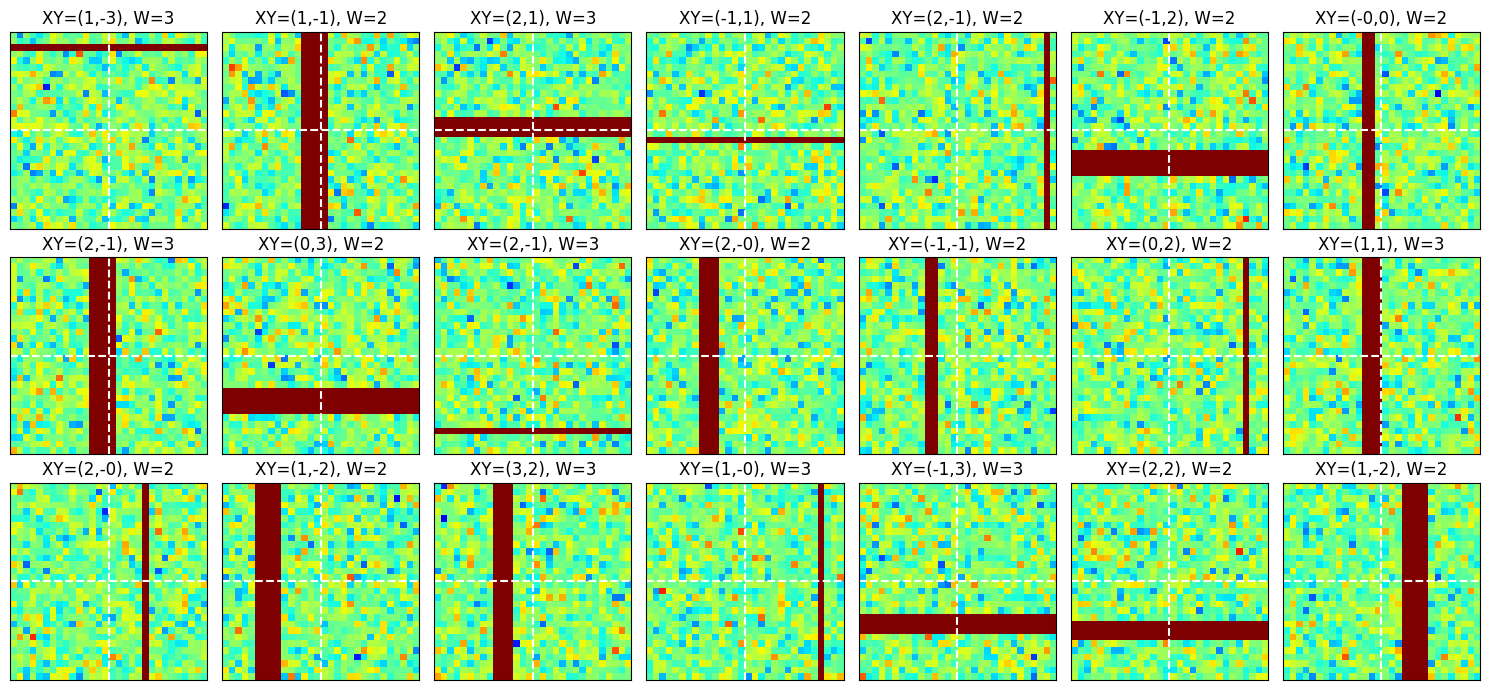

In [102]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(15,7))

for i,ax in enumerate(axs.flatten()):
    whichpic = np.random.randint(nImages)
    G = np.squeeze( images[whichpic,:,:] )
    ax.imshow(G,vmin=-1,vmax=1,cmap='jet',extent=[-4,4,-4,4],origin='upper')
    # ax.imshow(G,vmin=-1,vmax=1,cmap='jet')#,extent=[-4,4,-4,4],origin='upper')
    ax.set_title(f'XY=({labels[whichpic,0]:.0f},{labels[whichpic,1]:.0f}), W={labels[whichpic,2]:.0f}')
    ax.plot([-4,4],[0,0],'w--')
    ax.plot([0,0],[-4,4],'w--')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()


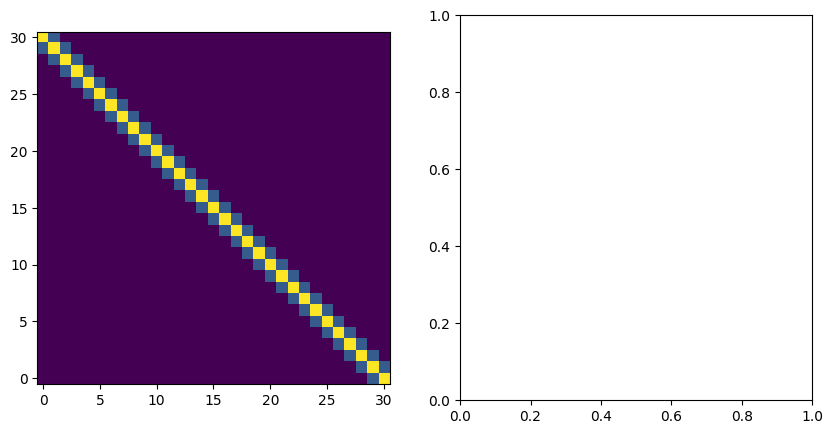

In [77]:
# imgSize = 31
# nImages = 10000

# x   = np.linspace(-4,4,imgSize)
# X,Y = np.meshgrid(x,x)

# img = np.zeros((imgSize, imgSize), dtype=np.uint8)
# y = ax

# # rr, cc, val = line_aa(0, 0, 0, 30) # Horizontal #start here, -> x2 increase -> +ve slope
# # rr, cc, val = line_aa(0, 0, 30, 30) # +ve slope -> y2 
# # rr, cc, val = line_aa(0, 0, 30, 0) # vertical 
# # rr, cc, val = line_aa(0, 30, 30, 0) # -ve slope

# # rr, cc, val = line_aa(30, 30, 0, 0)
# img[rr, cc] = val * 255
# fig,ax = plt.subplots(1,2,figsize=(10,5))
# # ax[0].set_xlim([-30,30])
# ax[0].imshow(img, origin="lower")
